# 自編碼器Auto-Encoder  (cntk)

###測試於cntk 2.6

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function 
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import codecs
import math
import random
import pickle
from PIL import Image

import cntk as C
from cntk.ops import *
from cntk.layers import *
from cntk.losses import *
from cntk.metrics import *
from cntk.debugging import *
from cntk.logging import *
from cntk.learners import *
from cntk.train import *
from cntk.device import *

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [3]:
C.__version__

'2.6'

In [4]:
train_data=None
test_data=None

with open('../Data/mnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('../Data/mnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)
    
def parse_mnist(data):
    features=[]
    labels=[]
    for row in data:
        labels.append(np.eye(10)[row[-1]].astype(np.float32))
        features.append(row[:-1].astype(np.float32)/255.0)#正規化
    return np.asarray(features),np.asarray(labels)



features,labels=parse_mnist(train_data)
print(features[:3])
print(features.shape)
print(labels.shape)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 784)
(60000, 10)


In [5]:
idxs=np.arange(0,train_data.shape[0])
random.shuffle(idxs)
idx=0
print(idxs.shape)
print(idxs)
def get_next_minibatch(minibatch_size):
    global idxs,idx
    features,labels=parse_mnist(train_data)
    x_features=[]
    y_labels=[]
    while len(x_features)<minibatch_size:
        x_features.append(features[idxs[idx]])
        y_labels.append(labels[idxs[idx]])
        idx+=1
        if idx>=len(idxs)-1:
            idx=0
            random.shuffle(idxs)
    return np.asarray(x_features).astype(np.float32),np.asarray(y_labels).astype(np.float32)

features_x,labels_y=get_next_minibatch(3)
print(features_x.shape)
print(labels_y.shape)

(60000,)
[36011 45993 39038 ... 22227  3257 34160]
(3, 784)
(3, 10)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5


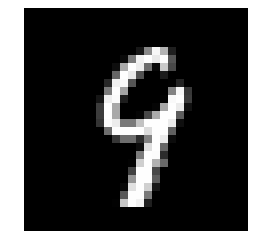

In [6]:
features_x,labels_y=get_next_minibatch(32)
img=Image.fromarray(np.reshape(features_x[0,:]*255,(28,28)).astype(np.uint8))
plt.axis('off')
plt.imshow(img, cmap='gray', interpolation='nearest')

print(labels_y[0,:])
print(np.argmax(labels[0,:]))

In [7]:
def autoencoder(x):#基本型
    x=Dense(784,activation=C.relu)(x)
    x=Dense(512,activation=C.relu)(x)
    x=Dense(256,activation=C.relu)(x)
    x=Dense(128,activation=C.relu)(x)
    x=Dense(64,activation=C.relu)(x)
    x=Dense(32,activation=None)(x)
    x=Dense(64,activation=C.relu)(x)
    x=Dense(128,activation=C.relu)(x)
    x=Dense(256,activation=C.relu)(x)
    x=Dense(512,activation=C.relu)(x)
    x=Dense(784,activation=C.relu)(x)
    x=clip(x,0,1)
    return x

In [8]:
def autoencoder1(x):#加入批次正規化
    x=Dense(784,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(512,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(256,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(128,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(64,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(32,activation=None)(x)
    x=BatchNormalization()(x)
    x=Dense(64,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(128,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(256,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(512,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(784,activation=C.relu)(x)
    x=clip(x,0,1)
    return x

In [9]:
def autoencoder2(x):#加入dropout
    x=Dense(784,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(512,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(256,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Dense(128,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(64,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(32,activation=None)(x)
    x=Dense(64,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(128,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(256,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(512,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(784,activation=C.relu)(x)
    x=clip(x,0,1)
    return x

In [13]:
input_var=C.input_variable(784, dtype=np.float32, name='input_var')

z=autoencoder1(input_var)

loss=reduce_mean(squared_error(z,input_var))
errs=sqrt(reduce_sum(squared_error(z,input_var)/reduce_sum(input_var)))

In [14]:
progress_printer = ProgressPrinter(freq=200, tag='Training', num_epochs=300)

learning_rate=0.001
minibatch_size=64
num_epochs=3
learner = adam(z.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, 300),
               momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(0.95)], epoch_size=300),
               l1_regularization_weight=0.0001, l2_regularization_weight=5e-3)

trainer = Trainer(z, (loss, errs), learner, progress_printer)

In [15]:
for epoch_count in range(num_epochs):
    mbs = 0
    while mbs < len(features)/minibatch_size:
        features_x,labels_y=get_next_minibatch(minibatch_size)
        trainer.train_minibatch({input_var: features_x})
        if mbs%5==0:
            z.save('Models/autoencoder_cntk.onnx', format=C.ModelFormat.ONNX)
        mbs+=1
    trainer.summarize_training_progress()

Learning rate per 1 samples: 0.001
 Minibatch[   1- 200]: loss = 52.246924 * 12800, metric = 69.55% * 12800;
 Minibatch[ 201- 400]: loss = 29.119600 * 12800, metric = 53.10% * 12800;
 Minibatch[ 401- 600]: loss = 24.098730 * 12800, metric = 48.34% * 12800;
 Minibatch[ 601- 800]: loss = 21.832549 * 12800, metric = 46.04% * 12800;
Finished Epoch[1 of 300]: [Training] loss = 30.160929 * 60032, metric = 52.84% * 60032 1459.068s ( 41.1 samples/s);
 Minibatch[   1- 200]: loss = 19.379070 * 12800, metric = 43.27% * 12800;
 Minibatch[ 201- 400]: loss = 18.251555 * 12800, metric = 42.13% * 12800;
 Minibatch[ 401- 600]: loss = 17.549365 * 12800, metric = 41.30% * 12800;
 Minibatch[ 601- 800]: loss = 16.602124 * 12800, metric = 40.31% * 12800;
Finished Epoch[2 of 300]: [Training] loss = 17.664200 * 60032, metric = 41.42% * 60032 1389.125s ( 43.2 samples/s);
 Minibatch[   1- 200]: loss = 15.431359 * 12800, metric = 38.84% * 12800;
 Minibatch[ 201- 400]: loss = 15.075096 * 12800, metric = 38.28% * 

(28, 28)
(28, 28)


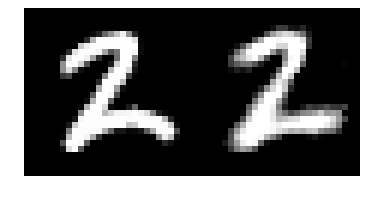

In [17]:
features_x,labels_y=get_next_minibatch(minibatch_size)
results=z(features_x)#產生預測結果
#實際值
actual=np.reshape(features_x[0,:]*255,(28,28)).astype(np.uint8)
pred=np.reshape(results[0,:]*255,(28,28)).astype(np.uint8)
print(actual.shape)
print(pred.shape)
img=Image.fromarray(np.concatenate([actual,pred],axis=-1))
plt.axis('off')
plt.imshow(img, cmap='gray', interpolation='nearest')


# 去噪自編碼器 Denoise AutoEncoder

<img src="../Images/denoise.jpg">

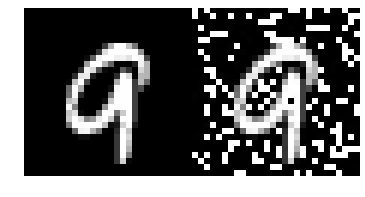

In [18]:
def get_next_noise_minibatch(minibatch_size):
    global idxs,idx
    features,labels=parse_mnist(train_data)
    x_features=[]
    x_noise=[]
    while len(x_features)<minibatch_size:
        x_features.append(features[idxs[idx]])
        x_noise.append(features[idxs[idx]]+np.random.standard_normal(784)*0.005)
        idx+=1
        if idx>=len(idxs):
            idx=0
            random.shuffle(idxs)
    return np.asarray(x_features).astype(np.float32),np.asarray(x_noise).astype(np.float32)

features_x,noise_x=get_next_noise_minibatch(3)
actual=np.reshape(features_x[0,:]*255,(28,28)).astype(np.uint8)
noise=np.reshape(noise_x[0,:]*255,(28,28)).astype(np.uint8)

img=Image.fromarray(np.concatenate([actual,noise],axis=-1))
plt.axis('off')
plt.imshow(img, cmap='gray', interpolation='nearest')

In [19]:
input_var=C.input_variable(784, dtype=np.float32, name='input_var')
noise_var=C.input_variable(784, dtype=np.float32, name='input_var')

z_denoise=autoencoder1(noise_var)

loss=reduce_sum(squared_error(z_denoise,input_var))
errs=sqrt(reduce_sum(squared_error(z_denoise,input_var)/reduce_sum(input_var)))

In [20]:
learning_rate=0.001
minibatch_size=64
num_epochs=3
progress_printer1 = ProgressPrinter(freq=200, tag='Training', num_epochs=300)

learner1 = adam(z_denoise.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, 300),
               momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(0.95)], epoch_size=300),
               l1_regularization_weight=0.0001, l2_regularization_weight=5e-3)

trainer1 = Trainer(z_denoise, (loss, errs), learner1, progress_printer1)

for epoch_count in range(num_epochs):
    mbs = 0
    while mbs < len(features)/minibatch_size:
        raw_features,raw_noise=get_next_noise_minibatch(minibatch_size)
        trainer1.train_minibatch({input_var: raw_features,noise_var:raw_noise})
        if mbs%5==0:
            z_denoise.save('Models/denoise_autoencoder_cntk.onnx', format=C.ModelFormat.ONNX)
        mbs+=1
    #trainer1.summarize_training_progress()

Learning rate per 1 samples: 0.001
 Minibatch[   1- 200]: loss = 57.960845 * 12800, metric = 72.47% * 12800;
 Minibatch[ 201- 400]: loss = 29.561450 * 12800, metric = 53.14% * 12800;
 Minibatch[ 401- 600]: loss = 25.378896 * 12800, metric = 49.11% * 12800;
 Minibatch[ 601- 800]: loss = 22.829766 * 12800, metric = 46.34% * 12800;
 Minibatch[ 801-1000]: loss = 21.080400 * 12800, metric = 44.43% * 12800;
 Minibatch[1001-1200]: loss = 20.115811 * 12800, metric = 43.34% * 12800;
 Minibatch[1201-1400]: loss = 18.788730 * 12800, metric = 41.83% * 12800;
 Minibatch[1401-1600]: loss = 19.069629 * 12800, metric = 42.07% * 12800;
 Minibatch[1601-1800]: loss = 17.439238 * 12800, metric = 40.26% * 12800;
 Minibatch[1801-2000]: loss = 16.937695 * 12800, metric = 39.60% * 12800;
 Minibatch[2001-2200]: loss = 17.165547 * 12800, metric = 39.71% * 12800;
 Minibatch[2201-2400]: loss = 17.114395 * 12800, metric = 39.75% * 12800;
 Minibatch[2401-2600]: loss = 16.206289 * 12800, metric = 38.56% * 12800;
 Mi

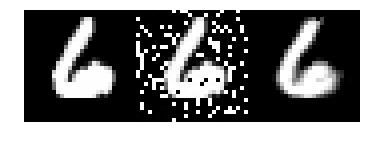

In [21]:
raw_features,raw_noise=get_next_noise_minibatch(minibatch_size)
results=z_denoise(raw_noise)#產生預測結果
#實際值
actual=np.reshape(raw_features[0,:]*255,(28,28)).astype(np.uint8)
noise=np.reshape(raw_noise[0,:]*255,(28,28)).astype(np.uint8)
pred=np.reshape(results[0,:]*255,(28,28)).astype(np.uint8)

img=Image.fromarray(np.concatenate([actual,noise,pred],axis=-1))
plt.axis('off')
plt.imshow(img, cmap='gray', interpolation='nearest')

# 變分自編碼器（VAE）

In [22]:
def vae_encoder(x):
    x=Dense(784,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(512,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(256,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(128,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(64,activation=C.relu)(x)
    x=BatchNormalization()(x)
    return x

def vae_decoder(x):
    x=Dense(32,activation=None)(x)
    x=BatchNormalization()(x)
    x=Dense(64,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(128,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(256,activation=C.relu)(x)
    x=BatchNormalization()(x)
    x=Dense(512,activation=C.relu)(x)
 
 
    return x

latent_dim = 32 # 隱變量維度數

h = vae_encoder(input_var)

# 算p(Z|X)的均值和方差
z_mean = Dense(32)(h)
z_log_var = Dense(32)(h)


#epsilon表示隨機成分
epsilon =C.random.normal(shape=(latent_dim), mean=0.,scale=1)
z=z_mean +exp(z_log_var/2)#* epsilon

#如果不處理epsilon，則為AUTOENCODER
#如果處理epsilon，則為生成模型


#解碼層
decoder_mean = Dense(784, activation=sigmoid)
h_decoded = vae_decoder(z)
z_vae= decoder_mean(h_decoded)


In [23]:
xent_loss = 784*binary_cross_entropy(z_vae,input_var)#重構損失
kl_loss = - 0.5 * reduce_sum(1 + z_log_var - square(z_mean) - exp(z_log_var), axis=-1)#KL散度
vae_loss = reduce_mean(xent_loss + kl_loss)

loss=vae_loss
errs=sqrt(reduce_sum(squared_error(z_vae,input_var)/reduce_sum(input_var)))

In [24]:
progress_printer2 = ProgressPrinter(freq=200, tag='Training', num_epochs=300)

learning_rate=0.0001
minibatch_size=64
num_epochs=5
learner2 = adam(z_vae.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, 300),
               momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(0.95)], epoch_size=300),
               l1_regularization_weight=0.0001, l2_regularization_weight=5e-3)

trainer2 = Trainer(z_vae, (loss, errs), learner2, progress_printer2)
for epoch_count in range(num_epochs):
    mbs = 0
    while mbs < len(features)/minibatch_size:
        raw_features,raw_labels=get_next_minibatch(minibatch_size)
        trainer2.train_minibatch({input_var: raw_features})
        if mbs%5==0:
            z_vae.save('Models/vae_cntk.model')
        mbs+=1
    trainer2.summarize_training_progress()

Learning rate per 1 samples: 0.0001
 Minibatch[   1- 200]: loss = 326.300176 * 12800, metric = 88.29% * 12800;
 Minibatch[ 201- 400]: loss = 180.122598 * 12800, metric = 60.61% * 12800;
 Minibatch[ 401- 600]: loss = 157.068008 * 12800, metric = 56.20% * 12800;
 Minibatch[ 601- 800]: loss = 144.291406 * 12800, metric = 53.31% * 12800;
Finished Epoch[1 of 300]: [Training] loss = 192.565165 * 60032, metric = 62.73% * 60032 777.600s ( 77.2 samples/s);
 Minibatch[   1- 200]: loss = 134.552002 * 12800, metric = 50.89% * 12800;
 Minibatch[ 201- 400]: loss = 129.410342 * 12800, metric = 49.48% * 12800;
 Minibatch[ 401- 600]: loss = 126.434531 * 12800, metric = 48.49% * 12800;
 Minibatch[ 601- 800]: loss = 123.272695 * 12800, metric = 47.56% * 12800;
Finished Epoch[2 of 300]: [Training] loss = 127.373984 * 60032, metric = 48.79% * 60032 810.559s ( 74.1 samples/s);
 Minibatch[   1- 200]: loss = 118.945459 * 12800, metric = 46.15% * 12800;
 Minibatch[ 201- 400]: loss = 117.724893 * 12800, metric 

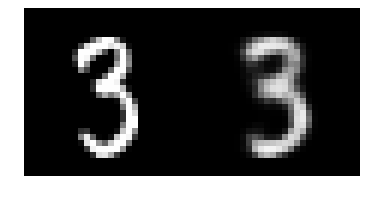

In [25]:
raw_features,raw_labels=get_next_minibatch(minibatch_size)
results=z_vae(raw_features)#產生預測結果
#實際值
actual=np.reshape(raw_features[0,:]*255,(28,28)).astype(np.uint8)
pred=np.reshape(results[0,:]*255,(28,28)).astype(np.uint8)

img=Image.fromarray(np.concatenate([actual,pred],axis=-1))
plt.axis('off')
plt.imshow(img, cmap='gray', interpolation='nearest')